In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.float_format', lambda x: '%.3f' % x) #avoid scientific notation
import datetime
import sys
import pickle
import joblib

In [92]:
# reading csv
dataset = pd.read_csv('yahoo_BTC-USD.csv')
dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864,468.174,452.422,457.334,457.334,21056800.000
1,2014-09-18,456.860,456.860,413.104,424.440,424.440,34483200.000
2,2014-09-19,424.103,427.835,384.532,394.796,394.796,37919700.000
3,2014-09-20,394.673,423.296,389.883,408.904,408.904,36863600.000
4,2014-09-21,408.085,412.426,393.181,398.821,398.821,26580100.000
...,...,...,...,...,...,...,...
2449,2021-06-01,37293.793,37896.734,35787.086,36684.926,36684.926,34639423297.000
2450,2021-06-02,36699.922,38231.340,35966.309,37575.180,37575.180,33070867190.000
2451,2021-06-03,37599.410,39478.953,37243.973,39208.766,39208.766,35460750427.000
2452,2021-06-04,39242.484,39242.484,35717.723,36894.406,36894.406,41831090187.000


In [93]:
# checking if close is not equal to adj close
dataset[dataset['Close']!=dataset['Adj Close']]

,Date,Open,High,Low,Close,Adj Close,Volume
2039,2020-04-17,nan,nan,nan,nan,nan,nan
2214,2020-10-09,nan,nan,nan,nan,nan,nan
2217,2020-10-12,nan,nan,nan,nan,nan,nan
2218,2020-10-13,nan,nan,nan,nan,nan,nan


In [94]:
# checking for nulls
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2454 entries, 0 to 2453
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2454 non-null   object 
 1   Open       2450 non-null   float64
 2   High       2450 non-null   float64
 3   Low        2450 non-null   float64
 4   Close      2450 non-null   float64
 5   Adj Close  2450 non-null   float64
 6   Volume     2450 non-null   float64
dtypes: float64(6), object(1)
memory usage: 134.3+ KB


In [95]:
# use close only and fill NaN with ffil
df = dataset.set_index('Date')[['Close']].tail(2000)
df = df.set_index(pd.to_datetime(df.index))
df.fillna(method='ffill',inplace=True)

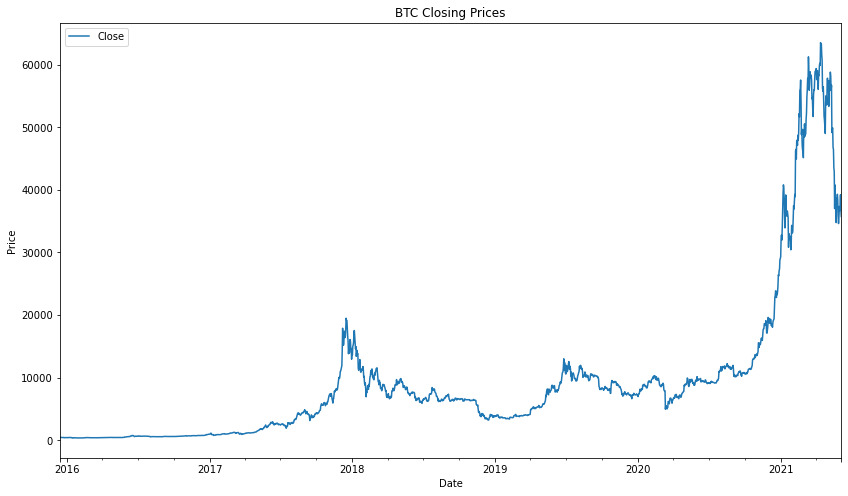

In [96]:
# plotting the Closing Prices
df.plot(figsize=(14,8))
plt.title('BTC Closing Prices')
plt.ylabel('Price')
plt.show()

In [97]:
# train test split
prediction_days = 10
df_train = df.head(-prediction_days)
df_test = df.tail(prediction_days)
training_set = df_train.values
test_set = df_test.values
print('training_set.shape = ', training_set.shape)
print('test_set.shape = ', test_set.shape)

training_set.shape =  (1990, 1)
test_set.shape =  (10, 1)


In [98]:
# scale
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled

array([[0.00159948],
       [0.00143497],
       [0.00145309],
       ...,
       [0.60725658],
       [0.60244565],
       [0.61657281]])

In [99]:
training_set_scaled.shape

(1990, 1)

In [100]:
len(training_set_scaled)

1990

In [101]:
# creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
 
n_future = prediction_days #20  # Number of days you want to predict into the future
n_past = 60  # Number of past days you want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future + 1):
    X_train.append(training_set_scaled[i-n_past:i, 0])
    y_train.append(training_set_scaled[i:i+n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# another efficient and nice way
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
# https://github.com/marcosan93/Price-Forecaster/blob/master/BTC-Models/BTC-RNN-Deep-Learning.ipynb
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the univariate time sequence
    """
    X, y = [], []
    
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        if out_end > len(seq):
            break
        
        seq_x, seq_y = seq[i:end], seq[end:out_end]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)
X, y = split_sequence(training_set, 60, 7)
X.shape, y.shape

In [102]:
X_train.shape, y_train.shape

((1921, 60), (1921, 10))

In [103]:
range(n_past, len(training_set_scaled) - n_future + 1)

range(60, 1981)

In [104]:
range(n_past, len(training_set_scaled)-7)

range(60, 1983)

In [105]:
for i in range(n_past, len(training_set_scaled) - n_future + 1):
    print('i={}, [{}, {})'.format(i, i-n_past, i))

i=60, [0, 60)
i=61, [1, 61)
i=62, [2, 62)
i=63, [3, 63)
i=64, [4, 64)
i=65, [5, 65)
i=66, [6, 66)
i=67, [7, 67)
i=68, [8, 68)
i=69, [9, 69)
i=70, [10, 70)
i=71, [11, 71)
i=72, [12, 72)
i=73, [13, 73)
i=74, [14, 74)
i=75, [15, 75)
i=76, [16, 76)
i=77, [17, 77)
i=78, [18, 78)
i=79, [19, 79)
i=80, [20, 80)
i=81, [21, 81)
i=82, [22, 82)
i=83, [23, 83)
i=84, [24, 84)
i=85, [25, 85)
i=86, [26, 86)
i=87, [27, 87)
i=88, [28, 88)
i=89, [29, 89)
i=90, [30, 90)
i=91, [31, 91)
i=92, [32, 92)
i=93, [33, 93)
i=94, [34, 94)
i=95, [35, 95)
i=96, [36, 96)
i=97, [37, 97)
i=98, [38, 98)
i=99, [39, 99)
i=100, [40, 100)
i=101, [41, 101)
i=102, [42, 102)
i=103, [43, 103)
i=104, [44, 104)
i=105, [45, 105)
i=106, [46, 106)
i=107, [47, 107)
i=108, [48, 108)
i=109, [49, 109)
i=110, [50, 110)
i=111, [51, 111)
i=112, [52, 112)
i=113, [53, 113)
i=114, [54, 114)
i=115, [55, 115)
i=116, [56, 116)
i=117, [57, 117)
i=118, [58, 118)
i=119, [59, 119)
i=120, [60, 120)
i=121, [61, 121)
i=122, [62, 122)
i=123, [63, 123)
i=

i=1619, [1559, 1619)
i=1620, [1560, 1620)
i=1621, [1561, 1621)
i=1622, [1562, 1622)
i=1623, [1563, 1623)
i=1624, [1564, 1624)
i=1625, [1565, 1625)
i=1626, [1566, 1626)
i=1627, [1567, 1627)
i=1628, [1568, 1628)
i=1629, [1569, 1629)
i=1630, [1570, 1630)
i=1631, [1571, 1631)
i=1632, [1572, 1632)
i=1633, [1573, 1633)
i=1634, [1574, 1634)
i=1635, [1575, 1635)
i=1636, [1576, 1636)
i=1637, [1577, 1637)
i=1638, [1578, 1638)
i=1639, [1579, 1639)
i=1640, [1580, 1640)
i=1641, [1581, 1641)
i=1642, [1582, 1642)
i=1643, [1583, 1643)
i=1644, [1584, 1644)
i=1645, [1585, 1645)
i=1646, [1586, 1646)
i=1647, [1587, 1647)
i=1648, [1588, 1648)
i=1649, [1589, 1649)
i=1650, [1590, 1650)
i=1651, [1591, 1651)
i=1652, [1592, 1652)
i=1653, [1593, 1653)
i=1654, [1594, 1654)
i=1655, [1595, 1655)
i=1656, [1596, 1656)
i=1657, [1597, 1657)
i=1658, [1598, 1658)
i=1659, [1599, 1659)
i=1660, [1600, 1660)
i=1661, [1601, 1661)
i=1662, [1602, 1662)
i=1663, [1603, 1663)
i=1664, [1604, 1664)
i=1665, [1605, 1665)
i=1666, [1606

In [106]:
for i in range(n_past, len(training_set_scaled) - n_future + 1):
    print('i={}, [{}, {})'.format(i, i, i+n_future)) #  i,'-', i, '-', i+n_future)

i=60, [60, 70)
i=61, [61, 71)
i=62, [62, 72)
i=63, [63, 73)
i=64, [64, 74)
i=65, [65, 75)
i=66, [66, 76)
i=67, [67, 77)
i=68, [68, 78)
i=69, [69, 79)
i=70, [70, 80)
i=71, [71, 81)
i=72, [72, 82)
i=73, [73, 83)
i=74, [74, 84)
i=75, [75, 85)
i=76, [76, 86)
i=77, [77, 87)
i=78, [78, 88)
i=79, [79, 89)
i=80, [80, 90)
i=81, [81, 91)
i=82, [82, 92)
i=83, [83, 93)
i=84, [84, 94)
i=85, [85, 95)
i=86, [86, 96)
i=87, [87, 97)
i=88, [88, 98)
i=89, [89, 99)
i=90, [90, 100)
i=91, [91, 101)
i=92, [92, 102)
i=93, [93, 103)
i=94, [94, 104)
i=95, [95, 105)
i=96, [96, 106)
i=97, [97, 107)
i=98, [98, 108)
i=99, [99, 109)
i=100, [100, 110)
i=101, [101, 111)
i=102, [102, 112)
i=103, [103, 113)
i=104, [104, 114)
i=105, [105, 115)
i=106, [106, 116)
i=107, [107, 117)
i=108, [108, 118)
i=109, [109, 119)
i=110, [110, 120)
i=111, [111, 121)
i=112, [112, 122)
i=113, [113, 123)
i=114, [114, 124)
i=115, [115, 125)
i=116, [116, 126)
i=117, [117, 127)
i=118, [118, 128)
i=119, [119, 129)
i=120, [120, 130)
i=121, [121,

In [107]:
training_set.shape

(1990, 1)

In [108]:
training_set[-1]

array([39294.199219])

In [109]:
#training_set[1993]

# creating a data structure with 60 timesteps and 1 output
days_used = 60
X_train = []
y_train = []
for i in range(days_used, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-days_used:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [110]:
X_train.shape, y_train.shape

((1921, 60), (1921, 10))

In [111]:
# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1921, 60, 1)

In [112]:
# building the RNN

activation = 'softsign'

# Initialising the RNN
regressor = Sequential()

# Adding the first layer of the LSTM and some Drouput regularisation
regressor.add(LSTM(units=5, return_sequences=True, input_shape=(X_train.shape[1], 1))) #, activation='sigmoid'
# units is the number of neurons. 50 neurones is high dimensionality.
# return_sequences is because we are using stacked RNN, so another layer will come afterwards
#regressor.add(Dropout(0.3))
# 20% of the neurons will be dropped/ignored during training (20% of 50, then 10 will be ignored)

# Adding the second LSTM layer and some Drouput regularisation
regressor.add(LSTM(units=5, return_sequences=True, activation=activation))
#regressor.add(Dropout(0.3))

# Adding the third LSTM layer and some Drouput regularisation
regressor.add(LSTM(units=5, return_sequences=True, activation=activation))
#regressor.add(Dropout(0.3))

# Adding the fourth LSTM layer and some Drouput regularisation
#regressor.add(LSTM(units=50, return_sequences=True, activation=activation))
#regressor.add(Dropout(0.3))
regressor.add(LSTM(units=5, return_sequences=True, activation=activation))
regressor.add(LSTM(units=5, return_sequences=True, activation=activation))
regressor.add(LSTM(units=5, return_sequences=True, activation=activation))

# Adding the fifth LSTM layer and some Drouput regularisation
regressor.add(LSTM(units=5, return_sequences=False, activation=activation))
#regressor.add(Dropout(0.3))

# Adding the output layer
regressor.add(Dense(units=prediction_days))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
#try also with RMSprop

# Model summary
regressor.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 60, 5)             140       
_________________________________________________________________
lstm_32 (LSTM)               (None, 60, 5)             220       
_________________________________________________________________
lstm_33 (LSTM)               (None, 60, 5)             220       
_________________________________________________________________
lstm_34 (LSTM)               (None, 60, 5)             220       
_________________________________________________________________
lstm_35 (LSTM)               (None, 60, 5)             220       
_________________________________________________________________
lstm_36 (LSTM)               (None, 60, 5)             220       
_________________________________________________________________
lstm_37 (LSTM)               (None, 5)                

In [113]:
# Fitting the RNN to the Training set
res = regressor.fit(X_train, y_train, batch_size=30, epochs=800, validation_split=0.1) #100/32 / 250 , validation_split=0.1)
# the smaller the btach, the less overfitting, normally a number poewr of 2, 32,64,128, etc

Epoch 1/800
58/58 [==============================] - 15s 110ms/step - loss: 0.0088 - accuracy: 0.0931 - val_loss: 0.3784 - val_accuracy: 0.0518
Epoch 2/800
58/58 [==============================] - 4s 71ms/step - loss: 0.0034 - accuracy: 0.0610 - val_loss: 0.3281 - val_accuracy: 0.0518
Epoch 3/800
58/58 [==============================] - 4s 69ms/step - loss: 0.0018 - accuracy: 0.1489 - val_loss: 0.3027 - val_accuracy: 0.1451
Epoch 4/800
58/58 [==============================] - 4s 70ms/step - loss: 0.0012 - accuracy: 0.1298 - val_loss: 0.2850 - val_accuracy: 0.1451
Epoch 5/800
58/58 [==============================] - 4s 70ms/step - loss: 8.3047e-04 - accuracy: 0.0971 - val_loss: 0.2793 - val_accuracy: 0.1451
Epoch 6/800
58/58 [==============================] - 4s 72ms/step - loss: 7.2554e-04 - accuracy: 0.0761 - val_loss: 0.2644 - val_accuracy: 0.0725
Epoch 7/800
58/58 [==============================] - 4s 71ms/step - loss: 6.3127e-04 - accuracy: 0.0944 - val_loss: 0.2561 - val_accuracy:

Epoch 57/800
58/58 [==============================] - 4s 71ms/step - loss: 2.8704e-04 - accuracy: 0.1292 - val_loss: 0.1726 - val_accuracy: 0.0725
Epoch 58/800
58/58 [==============================] - 4s 72ms/step - loss: 2.7555e-04 - accuracy: 0.1241 - val_loss: 0.1711 - val_accuracy: 0.0725
Epoch 59/800
58/58 [==============================] - 4s 72ms/step - loss: 2.3725e-04 - accuracy: 0.1504 - val_loss: 0.1736 - val_accuracy: 0.0725
Epoch 60/800
58/58 [==============================] - 4s 73ms/step - loss: 2.4133e-04 - accuracy: 0.1059 - val_loss: 0.1722 - val_accuracy: 0.0725
Epoch 61/800
58/58 [==============================] - 4s 74ms/step - loss: 2.4733e-04 - accuracy: 0.1227 - val_loss: 0.1789 - val_accuracy: 0.0725
Epoch 62/800
58/58 [==============================] - 4s 71ms/step - loss: 2.4825e-04 - accuracy: 0.1423 - val_loss: 0.1723 - val_accuracy: 0.0725
Epoch 63/800
58/58 [==============================] - 4s 71ms/step - loss: 2.9733e-04 - accuracy: 0.1434 - val_loss: 0

58/58 [==============================] - 4s 70ms/step - loss: 1.1414e-04 - accuracy: 0.1780 - val_loss: 0.2124 - val_accuracy: 0.1606
Epoch 168/800
58/58 [==============================] - 4s 70ms/step - loss: 1.2766e-04 - accuracy: 0.1388 - val_loss: 0.2135 - val_accuracy: 0.1606
Epoch 169/800
58/58 [==============================] - 4s 70ms/step - loss: 1.2565e-04 - accuracy: 0.1690 - val_loss: 0.2130 - val_accuracy: 0.1606
Epoch 170/800
58/58 [==============================] - 4s 69ms/step - loss: 1.2874e-04 - accuracy: 0.1399 - val_loss: 0.2148 - val_accuracy: 0.1710
Epoch 171/800
58/58 [==============================] - 4s 70ms/step - loss: 1.3608e-04 - accuracy: 0.1437 - val_loss: 0.2116 - val_accuracy: 0.1658
Epoch 172/800
58/58 [==============================] - 4s 70ms/step - loss: 1.3393e-04 - accuracy: 0.1907 - val_loss: 0.2076 - val_accuracy: 0.1658
Epoch 173/800
58/58 [==============================] - 4s 69ms/step - loss: 1.4206e-04 - accuracy: 0.1741 - val_loss: 0.2112 -

58/58 [==============================] - 9s 161ms/step - loss: 1.1705e-04 - accuracy: 0.1604 - val_loss: 0.2163 - val_accuracy: 0.1658
Epoch 278/800
58/58 [==============================] - 9s 162ms/step - loss: 1.0553e-04 - accuracy: 0.1880 - val_loss: 0.2149 - val_accuracy: 0.1606
Epoch 279/800
58/58 [==============================] - 9s 163ms/step - loss: 1.0569e-04 - accuracy: 0.1614 - val_loss: 0.2119 - val_accuracy: 0.1554
Epoch 280/800
58/58 [==============================] - 9s 164ms/step - loss: 1.0121e-04 - accuracy: 0.2012 - val_loss: 0.2122 - val_accuracy: 0.1606
Epoch 281/800
58/58 [==============================] - 9s 163ms/step - loss: 1.0301e-04 - accuracy: 0.1806 - val_loss: 0.2137 - val_accuracy: 0.1606
Epoch 282/800
58/58 [==============================] - 9s 162ms/step - loss: 1.3236e-04 - accuracy: 0.1371 - val_loss: 0.2191 - val_accuracy: 0.1554
Epoch 283/800
58/58 [==============================] - 9s 160ms/step - loss: 1.1290e-04 - accuracy: 0.1555 - val_loss: 0

58/58 [==============================] - 9s 161ms/step - loss: 1.0623e-04 - accuracy: 0.1551 - val_loss: 0.2166 - val_accuracy: 0.1606
Epoch 333/800
58/58 [==============================] - 9s 161ms/step - loss: 9.9651e-05 - accuracy: 0.1529 - val_loss: 0.2155 - val_accuracy: 0.1658
Epoch 334/800
58/58 [==============================] - 9s 161ms/step - loss: 1.1033e-04 - accuracy: 0.1465 - val_loss: 0.2149 - val_accuracy: 0.1606
Epoch 335/800
58/58 [==============================] - 9s 162ms/step - loss: 1.1038e-04 - accuracy: 0.1575 - val_loss: 0.2215 - val_accuracy: 0.1710
Epoch 336/800
58/58 [==============================] - 9s 162ms/step - loss: 1.0932e-04 - accuracy: 0.1694 - val_loss: 0.2184 - val_accuracy: 0.1710
Epoch 337/800
58/58 [==============================] - 9s 162ms/step - loss: 1.0299e-04 - accuracy: 0.1641 - val_loss: 0.2162 - val_accuracy: 0.1658
Epoch 338/800
58/58 [==============================] - 9s 161ms/step - loss: 1.0539e-04 - accuracy: 0.1545 - val_loss: 0

58/58 [==============================] - 9s 161ms/step - loss: 8.5564e-05 - accuracy: 0.1625 - val_loss: 0.2139 - val_accuracy: 0.1658
Epoch 388/800
58/58 [==============================] - 9s 161ms/step - loss: 8.3739e-05 - accuracy: 0.1512 - val_loss: 0.2125 - val_accuracy: 0.1658
Epoch 389/800
58/58 [==============================] - 9s 161ms/step - loss: 8.8211e-05 - accuracy: 0.1903 - val_loss: 0.2147 - val_accuracy: 0.1658
Epoch 390/800
58/58 [==============================] - 9s 163ms/step - loss: 9.1137e-05 - accuracy: 0.2295 - val_loss: 0.2152 - val_accuracy: 0.1606
Epoch 391/800
58/58 [==============================] - 9s 161ms/step - loss: 8.8069e-05 - accuracy: 0.1983 - val_loss: 0.2168 - val_accuracy: 0.1658
Epoch 392/800
58/58 [==============================] - 9s 162ms/step - loss: 8.1217e-05 - accuracy: 0.1859 - val_loss: 0.2146 - val_accuracy: 0.1606
Epoch 393/800
58/58 [==============================] - 9s 162ms/step - loss: 9.5022e-05 - accuracy: 0.1776 - val_loss: 0

58/58 [==============================] - 9s 163ms/step - loss: 8.2060e-05 - accuracy: 0.1594 - val_loss: 0.2104 - val_accuracy: 0.1606
Epoch 443/800
58/58 [==============================] - 9s 161ms/step - loss: 8.7215e-05 - accuracy: 0.1697 - val_loss: 0.2098 - val_accuracy: 0.1554
Epoch 444/800
58/58 [==============================] - 9s 161ms/step - loss: 9.2952e-05 - accuracy: 0.1614 - val_loss: 0.2118 - val_accuracy: 0.1606
Epoch 445/800
58/58 [==============================] - 9s 162ms/step - loss: 9.8858e-05 - accuracy: 0.1807 - val_loss: 0.2079 - val_accuracy: 0.0933
Epoch 446/800
58/58 [==============================] - 9s 163ms/step - loss: 8.8874e-05 - accuracy: 0.2050 - val_loss: 0.2089 - val_accuracy: 0.0984
Epoch 447/800
58/58 [==============================] - 9s 162ms/step - loss: 8.6855e-05 - accuracy: 0.1469 - val_loss: 0.2092 - val_accuracy: 0.1606
Epoch 448/800
58/58 [==============================] - 9s 160ms/step - loss: 9.1353e-05 - accuracy: 0.1563 - val_loss: 0

58/58 [==============================] - 9s 162ms/step - loss: 7.9231e-05 - accuracy: 0.1858 - val_loss: 0.2115 - val_accuracy: 0.1606
Epoch 498/800
58/58 [==============================] - 9s 163ms/step - loss: 7.9668e-05 - accuracy: 0.1946 - val_loss: 0.2111 - val_accuracy: 0.1140
Epoch 499/800
58/58 [==============================] - 9s 161ms/step - loss: 8.1931e-05 - accuracy: 0.1898 - val_loss: 0.2099 - val_accuracy: 0.1554
Epoch 500/800
58/58 [==============================] - 9s 162ms/step - loss: 8.1610e-05 - accuracy: 0.1673 - val_loss: 0.2116 - val_accuracy: 0.1865
Epoch 501/800
58/58 [==============================] - 10s 164ms/step - loss: 8.7553e-05 - accuracy: 0.1649 - val_loss: 0.2128 - val_accuracy: 0.1036
Epoch 502/800
58/58 [==============================] - 9s 161ms/step - loss: 7.7807e-05 - accuracy: 0.1661 - val_loss: 0.2079 - val_accuracy: 0.1658
Epoch 503/800
58/58 [==============================] - 9s 160ms/step - loss: 1.0016e-04 - accuracy: 0.1608 - val_loss: 

58/58 [==============================] - 9s 161ms/step - loss: 8.0422e-05 - accuracy: 0.1868 - val_loss: 0.2106 - val_accuracy: 0.1813
Epoch 553/800
58/58 [==============================] - 9s 160ms/step - loss: 9.6577e-05 - accuracy: 0.1613 - val_loss: 0.2088 - val_accuracy: 0.1036
Epoch 554/800
58/58 [==============================] - 9s 162ms/step - loss: 7.6593e-05 - accuracy: 0.1903 - val_loss: 0.2069 - val_accuracy: 0.1088
Epoch 555/800
58/58 [==============================] - 9s 162ms/step - loss: 7.4004e-05 - accuracy: 0.1623 - val_loss: 0.2081 - val_accuracy: 0.0881
Epoch 556/800
58/58 [==============================] - 9s 163ms/step - loss: 1.1550e-04 - accuracy: 0.1887 - val_loss: 0.2070 - val_accuracy: 0.0933
Epoch 557/800
58/58 [==============================] - 9s 160ms/step - loss: 1.1676e-04 - accuracy: 0.1317 - val_loss: 0.2103 - val_accuracy: 0.0933
Epoch 558/800
58/58 [==============================] - 9s 162ms/step - loss: 9.1458e-05 - accuracy: 0.2126 - val_loss: 0

58/58 [==============================] - 9s 163ms/step - loss: 6.9858e-05 - accuracy: 0.1976 - val_loss: 0.2068 - val_accuracy: 0.1244
Epoch 608/800
58/58 [==============================] - 9s 161ms/step - loss: 7.1055e-05 - accuracy: 0.1948 - val_loss: 0.2096 - val_accuracy: 0.1606
Epoch 609/800
58/58 [==============================] - 9s 160ms/step - loss: 7.0530e-05 - accuracy: 0.1914 - val_loss: 0.2071 - val_accuracy: 0.1140
Epoch 610/800
58/58 [==============================] - 9s 162ms/step - loss: 6.4261e-05 - accuracy: 0.1769 - val_loss: 0.2081 - val_accuracy: 0.1295
Epoch 611/800
58/58 [==============================] - 9s 161ms/step - loss: 6.5804e-05 - accuracy: 0.1906 - val_loss: 0.2077 - val_accuracy: 0.1192
Epoch 612/800
58/58 [==============================] - 9s 162ms/step - loss: 7.2445e-05 - accuracy: 0.1814 - val_loss: 0.2050 - val_accuracy: 0.1865
Epoch 613/800
58/58 [==============================] - 10s 164ms/step - loss: 9.8857e-05 - accuracy: 0.1756 - val_loss: 

58/58 [==============================] - 9s 164ms/step - loss: 6.9432e-05 - accuracy: 0.2026 - val_loss: 0.2092 - val_accuracy: 0.1140
Epoch 663/800
58/58 [==============================] - 9s 159ms/step - loss: 7.8217e-05 - accuracy: 0.2134 - val_loss: 0.2093 - val_accuracy: 0.1036
Epoch 664/800
58/58 [==============================] - 9s 162ms/step - loss: 8.1293e-05 - accuracy: 0.1886 - val_loss: 0.2059 - val_accuracy: 0.1088
Epoch 665/800
58/58 [==============================] - 9s 161ms/step - loss: 6.7986e-05 - accuracy: 0.1754 - val_loss: 0.2103 - val_accuracy: 0.1036
Epoch 666/800
58/58 [==============================] - 9s 162ms/step - loss: 7.7397e-05 - accuracy: 0.1811 - val_loss: 0.2087 - val_accuracy: 0.1036
Epoch 667/800
58/58 [==============================] - 9s 162ms/step - loss: 6.9248e-05 - accuracy: 0.1852 - val_loss: 0.2089 - val_accuracy: 0.0933
Epoch 668/800
58/58 [==============================] - 9s 162ms/step - loss: 6.8263e-05 - accuracy: 0.2063 - val_loss: 0

Epoch 717/800
58/58 [==============================] - 10s 173ms/step - loss: 7.0297e-05 - accuracy: 0.1899 - val_loss: 0.2072 - val_accuracy: 0.0518
Epoch 718/800
58/58 [==============================] - 10s 174ms/step - loss: 6.6015e-05 - accuracy: 0.1971 - val_loss: 0.2105 - val_accuracy: 0.1710
Epoch 719/800
58/58 [==============================] - 10s 175ms/step - loss: 7.1350e-05 - accuracy: 0.2102 - val_loss: 0.2067 - val_accuracy: 0.1036
Epoch 720/800
58/58 [==============================] - 10s 174ms/step - loss: 6.8441e-05 - accuracy: 0.1905 - val_loss: 0.2081 - val_accuracy: 0.1140
Epoch 721/800
58/58 [==============================] - 10s 175ms/step - loss: 6.3836e-05 - accuracy: 0.1906 - val_loss: 0.2074 - val_accuracy: 0.0933
Epoch 722/800
58/58 [==============================] - 10s 174ms/step - loss: 6.2655e-05 - accuracy: 0.1880 - val_loss: 0.2079 - val_accuracy: 0.0622
Epoch 723/800
58/58 [==============================] - 10s 170ms/step - loss: 7.0004e-05 - accuracy:

Epoch 772/800
58/58 [==============================] - 9s 162ms/step - loss: 6.8572e-05 - accuracy: 0.1915 - val_loss: 0.2066 - val_accuracy: 0.0674
Epoch 773/800
58/58 [==============================] - 9s 161ms/step - loss: 6.7862e-05 - accuracy: 0.2178 - val_loss: 0.2060 - val_accuracy: 0.0933
Epoch 774/800
58/58 [==============================] - 9s 162ms/step - loss: 6.5370e-05 - accuracy: 0.1821 - val_loss: 0.2082 - val_accuracy: 0.0829
Epoch 775/800
58/58 [==============================] - 9s 160ms/step - loss: 1.0708e-04 - accuracy: 0.1751 - val_loss: 0.1952 - val_accuracy: 0.0984
Epoch 776/800
58/58 [==============================] - 9s 160ms/step - loss: 1.7738e-04 - accuracy: 0.1499 - val_loss: 0.2049 - val_accuracy: 0.1503
Epoch 777/800
58/58 [==============================] - 9s 162ms/step - loss: 1.1936e-04 - accuracy: 0.1797 - val_loss: 0.2061 - val_accuracy: 0.0777
Epoch 778/800
58/58 [==============================] - 9s 160ms/step - loss: 1.0442e-04 - accuracy: 0.1669

In [114]:
list(res.history)

['loss', 'accuracy', 'val_loss', 'val_accuracy']

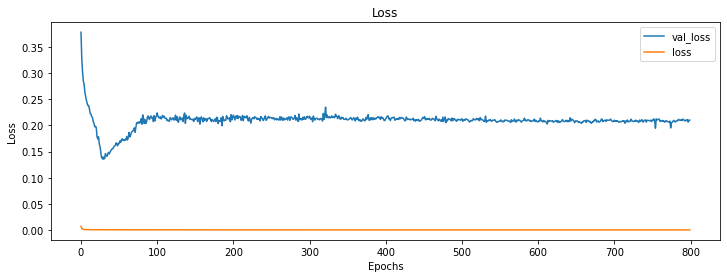

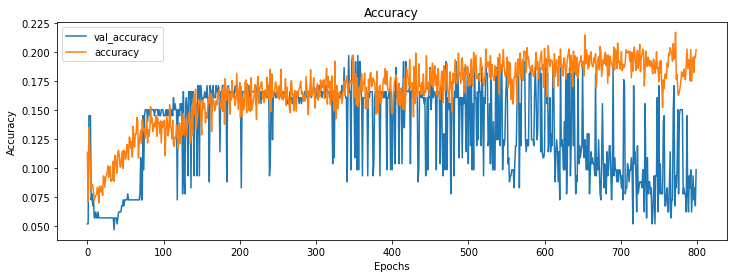

In [115]:
# Plotting Accuracy and Loss

results = res

history = results.history
plt.figure(figsize=(12,4))
plt.plot(history['val_loss'])
plt.plot(history['loss'])
plt.legend(['val_loss', 'loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(12,4))
plt.plot(history['val_accuracy'])
plt.plot(history['accuracy'])
plt.legend(['val_accuracy', 'accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

y_pred:
 [[16778.866088925563], [16783.81117705059], [16820.18241311172], [16430.10942101506], [16712.78104518471], [16581.087025928133], [16193.272064938788], [15816.357749120021], [15863.131922661827], [16150.29420619616]]
y_true:
 [[43537.511719], [42909.402344], [37002.441406], [40782.738281], [37304.691406], [37536.632813], [34770.582031], [38705.980469], [38402.222656], [39294.199219]]


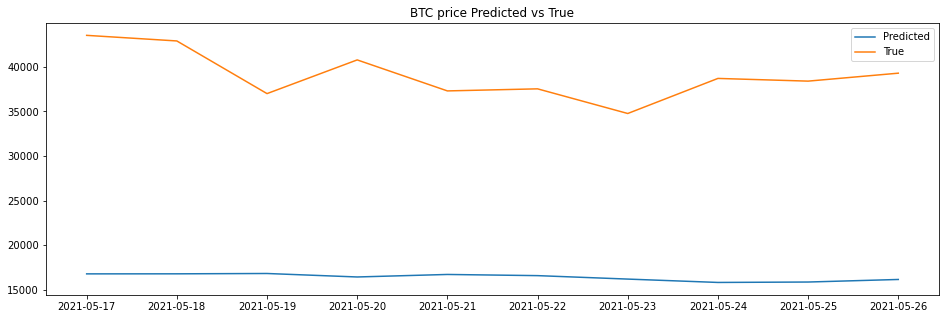

In [116]:
# Validation (validation with the last training days -> -15-15 DAYS)

# getting the predictions
y_pred = regressor.predict(X_train[-1].reshape(1, n_past, 1)).tolist()[0]
y_pred = sc.inverse_transform(np.array(y_pred).reshape(-1,1))#.tolist()

# getting the true values
y_true = sc.inverse_transform(y_train[-1].reshape(-1,1))

print('y_pred:\n', y_pred.tolist())
print('y_true:\n', y_true.tolist())

# plotting the results
plt.figure(figsize=(16,5))
plt.plot(y_pred, label='Predicted')
plt.plot(y_true, label='True')

dates = df_train.index[-prediction_days:]
dates = [str(dates.date[i]) for i in range(len(dates))]
plt.xticks(range(prediction_days),dates)

plt.title('BTC price Predicted vs True')
plt.legend()
plt.show()

y_pred:
 [[16789.858937033023], [16795.534121882753], [16832.626046205634], [16442.88423200471], [16726.536218013458], [16595.591112407474], [16208.080985617618], [15831.28803897087], [15878.596613208074], [16166.326227058122]]
y_true:
 [[38436.96875], [35697.605469], [34616.066406], [35678.128906], [37332.855469], [36684.925781], [37575.179688], [39208.765625], [36894.40625], [35746.101563]]


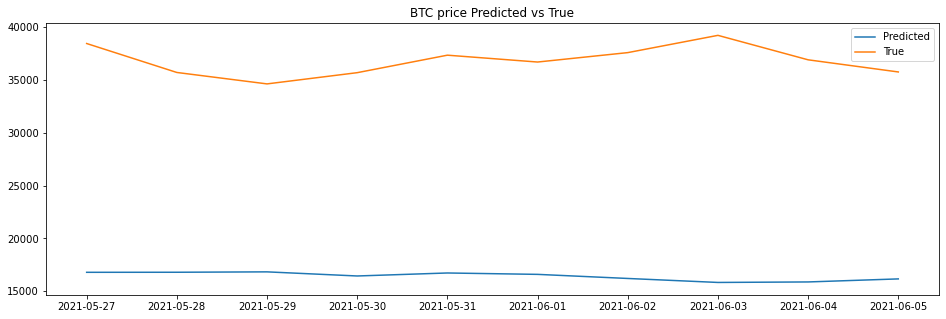

In [117]:
# Validation 2 (on the TEST SET -15 days)

# getting the predictions
x = df['Close'][-n_past-prediction_days:-prediction_days].values.reshape(-1,1)
#x = sc.transform(x)
y_pred = regressor.predict(x.reshape(1, n_past, 1)).tolist()[0]
y_pred = sc.inverse_transform(np.array(y_pred).reshape(-1,1))#.tolist()

# getting the true values
y_true = df.tail(prediction_days).values

print('y_pred:\n', y_pred.tolist())
print('y_true:\n', y_true.tolist())

# plotting the results
plt.figure(figsize=(16,5))
plt.plot(y_pred, label='Predicted')
plt.plot(y_true, label='True')

dates = df.index[-prediction_days:]
dates = [str(dates.date[i]) for i in range(len(dates))]
plt.xticks(range(prediction_days),dates)

plt.title('BTC price Predicted vs True')
plt.legend()
plt.show()

y_pred:
 [[16789.858937033023], [16795.534121882753], [16832.626046205634], [16442.88423200471], [16726.536218013458], [16595.591112407474], [16208.080985617618], [15831.28803897087], [15878.596613208074], [16166.326227058122]]
y_true:
 [[38436.96875], [35697.605469], [34616.066406], [35678.128906], [37332.855469], [36684.925781], [37575.179688], [39208.765625], [36894.40625], [35746.101563]]


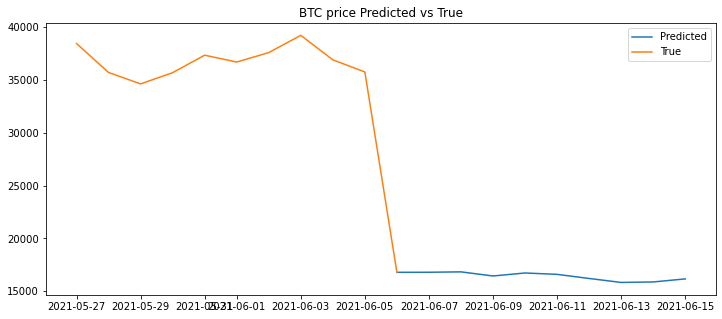

In [118]:
# Forecasting/Predicting

# getting the predictions
x = df.tail(n_past).values.reshape(-1,1)
#x = sc.transform(x)
y_pred = regressor.predict(x.reshape(1, n_past, 1)).tolist()[0]
y_pred = sc.inverse_transform(np.array(y_pred).reshape(-1,1))#.tolist()

# creating a DF of the predicted prices
y_pred_df = pd.DataFrame(y_pred, 
                         index=pd.date_range(start=df.index[-1]+datetime.timedelta(days=1),
                                             periods=len(y_pred), 
                                             freq="D"), 
                         columns=df.columns)

# getting the true values
y_true_df = df.tail(prediction_days)

# linking them
y_true_df = y_true_df.append(y_pred_df.head(1))

print('y_pred:\n', y_pred.tolist())
print('y_true:\n', y_true.tolist())

# plotting the results
plt.figure(figsize=(12,5))
plt.plot(y_pred_df, label='Predicted')
plt.plot(y_true_df, label='True')

#dates = df.index[-prediction_days:]
#dates = [str(dates.date[i]) for i in range(len(dates))]
#plt.xticks(range(prediction_days),dates)

plt.title('BTC price Predicted vs True')
plt.legend()
plt.show()

In [119]:
#database_filepath, model_filepath = sys.argv[1:]
#joblib.dump(regressor, 'regressor.pkl' , compress=6)

from tensorflow.keras.models import load_model
model.save('my_model.h5')
later_model = load_model('my_model.h5')
later_mode.predict(new_x)

**Improving the RNN**

Here are different ways to improve the RNN model:

Getting more training data: we trained our model on the past 5 years of the Google Stock Price but it would be even better to train it on the past 10 years.

Increasing the number of timesteps: the model remembered the stock prices from the 60 previous financial days to predict the stock price of the next day. That’s because we chose a number of 60 timesteps (3 months). You could try to increase the number of timesteps, by choosing for example 120 timesteps (6 months).

Adding some other indicators: if you have the financial instinct that the stock price of some other companies might be correlated to the one of Google, you could add this other stock price as a new indicator in the training data.

Adding more LSTM layers: we built a RNN with four LSTM layers but you could try with even more.

Adding more neurones in the LSTM layers: we highlighted the fact that we needed a high number of neurones in the LSTM layers to respond better to the complexity of the problem and we chose to include 50 neurones in each of our 4 LSTM layers. You could try an architecture with even more neurones in each of the 4 (or more) LSTM layers.

**Evaluating the RNN**

As seen in the practical lectures, the RNN we built was a regressor. Indeed, we were dealing with Regression because we were trying to predict a continuous outcome (the Google Stock Price). For Regression, the way to evaluate the model performance is with a metric called RMSE (Root Mean Squared Error). It is calculated as the root of the mean of the squared differences between the predictions and the real values.

However for our specific Stock Price Prediction problem, evaluating the model with the RMSE does not make much sense, since we are more interested in the directions taken by our predictions, rather than the closeness of their values to the real stock price. We want to check if our predictions follow the same directions as the real stock price and we don’t really care whether our predictions are close the real stock price. The predictions could indeed be close but often taking the opposite direction from the real stock price.

Nevertheless if you are interested in the code that computes the RMSE for our Stock Price Prediction problem, please find it just below:

import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
Then consider dividing this RMSE by the range of the Google Stock Price values of January 2017 (that is around 800) to get a relative error, as opposed to an absolute error. It is more relevant since for example if you get an RMSE of 50, then this error would be very big if the stock price values ranged around 100, but it would be very small if the stock price values ranged around 10000.

Enjoy Deep Learning!